# Fitting AUSF

The model requires the fitting of pig population dynamics and ASF disease dynamics. We first fit the population to ensure that the population returns to the carrying capacity

### Load Modules

In [29]:
1

1

In [1]:
using GpABC, Distances, Distributions, Plots, StatsBase, Printf
using DiffEqCallbacks, DifferentialEquations, LinearAlgebra
using DelimitedFiles, DataFrames, LinearAlgebra, SparseArrays
using QuadGK, Random

In [2]:
include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_model.jl");

In [3]:
input_path = "/home/callum/ASF/Inputs/"; #path to model data

### Model

In [4]:
input = ASF_Inputs.Model_Data(input_path, true); #loading the model input

In [5]:
const nt = input.Parameters.Populations.cum_sum[end] #total number of groups and farms
const nc = 5 #number of classes
const eqs = 11 #number of processes

const dc = sparse(zeros(nt*nc,nt*eqs))

#const _dc = zeros(nt*5,nt*10)

dc[0*nc*nt+1:nc*nt*eqs+nc:end] .= 1
dc[1*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[2*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+1:nc*nt*eqs+nc:end] .= 1

dc[2*nc*nt+2:nc*nt*eqs+nc:end] .= 1
dc[3*nc*nt+2:nc*nt*eqs+nc:end] .= -1
dc[4*nc*nt+2:nc*nt*eqs+nc:end] .= -1

dc[4*nc*nt+3:nc*nt*eqs+nc:end] .= 1
dc[5*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[6*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[7*nc*nt+3:nc*nt*eqs+nc:end] .= -1

dc[7*nc*nt+4:nc*nt*eqs+nc:end] .= 1
dc[8*nc*nt+4:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+4:nc*nt*eqs+nc:end] .= -1


dc[5*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[6*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[9*nc*nt+5:nc*nt*eqs+nc:end] .= -1;

In [6]:
function regular_c(du,u,p,t,counts,mark)  
    mul!(du,dc,counts)
    nothing
end

regular_c (generic function with 1 method)

In [7]:
# function that breaks up results into easy to analyse form
function run_analysis(sol)
   
        data = reduce(vcat,transpose.(sol.u))
        data[data .< 0 ] .= 0
   
        s_d = data[:,1:5:end]
        e_d = data[:,2:5:end]
        i_d = data[:,3:5:end]
        r_d = data[:,4:5:end]
        c_d = data[:,5:5:end]
 
        disease_total = e_d + i_d + c_d #classes with disease,
        disease_alive = e_d + i_d
 
        disease_free = s_d + r_d #classes without disease,
 
        disease_sum = sum(disease_total,dims=2)
        disease_alive_sum =  sum(disease_alive,dims=2)
        disease_free_sum = sum(disease_free,dims=2)
        population_sum = disease_alive_sum + disease_free_sum;
   
        return disease_sum, disease_alive_sum, disease_free_sum, population_sum
    end

run_analysis (generic function with 1 method)

In [8]:
input = ASF_Inputs.Model_Data(input_path, true); #loading the model input
params = ASF_Model.convert(input.Parameters); 

In [9]:
#Birth functions 

function birth_pulse_vector(t,k,s,p) #birth
    return k*exp(-s*cos(pi*(t+p)/365)^2)
end
function birth_pulse(t,k,s,p)
    return k.*exp.(-s.*cos.(pi.*(t.+p)./365).^2)
end

birth_pulse (generic function with 1 method)

### Fitting Population

In [10]:
AUSF_pop = function(params,Tspan, U0)
    #function that runs model for fitting

    rj = RegularJump(ASF_Model.asf_model_pop, regular_c, eqs*nt)

    prob = DiscreteProblem(U0,Tspan,params)

    jump_prob = JumpProblem(prob,Direct(),rj)

    ensemble_prob_m = EnsembleProblem(jump_prob)

    outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

    res = eval_out_pop(outputs,U0)

    return res
end
    

function simulator_function_pop(var_params)

   
    input = ASF_Inputs.Model_Data(input_path);

    U0 = copy(input.U0);
    U0[1:5:end] += (U0[2:5:end] +U0[3:5:end]) #setting init pop to zero
    U0[2:5:end] .= 0
    U0[3:5:end] .= 0;
    
    params = ASF_Model.convert(input.Parameters)
    
    params[15] = var_params[1] #The death modifier, to reduce population drift ove
    
    Time = (0.0,n_years*365)
    #now we run simulation!
    
    AUSF_pop(params, Time, U0)
end

function eval_out_pop(output, U0)
    
    output_final = Matrix{Float64}(undef,(n_years*365+1,1))
    dist = zeros(Float64,n_runs)
    K = sum(U0)
   dummy = zeros(n_years*365+1)
    
    for i = 1:n_runs
        sol = output[i]
        data = reduce(vcat,transpose.(sol.u))
        data[data .< 0 ] .= 0

        s_d = data[:,1:5:end]
        
        pop_sum = sum(s_d,dims=2)[:,1]
        
        pop_crop = pop_sum./ode_norm
 
        dummy += pop_crop/n_runs
        
    
    end
    output_final[:] = dummy
    dist = euclidean(obs[:],dummy)
   
    return output_final
    
end

function observed_params()
   
    obs =  Matrix{Float64}(undef,(n_years*365+1,1))
    
    obs .= 1
    
    return obs
end

observed_params (generic function with 1 method)

In [60]:
#Some key parameters for G

input_path = "/home/callum/ASF/Inputs/"; #path to model data
n_years = 5 #how many years each sim will run for
n_runs = 3 #how many runs for each param
obs = observed_params() #our observed (just array of ones, we normalise output to be relative to this)
priors = [Uniform(0.9, 1.0)];

In [61]:
#Need to figure out the observed, what the population without ASF should look like over time, will use ODE

input = ASF_Inputs.Model_Data(input_path);

U0_ode = [sum(input.U0)];

p_ode = [input.Parameters.k[1], input.Parameters.bw[1],input.Parameters.σ[1],sum(input.Parameters.K),input.Parameters.μ_p[1]];

tspan_ode = (0.0,n_years*365.0);

In [62]:
#ODE for population
function density_carrying!(du,u,p,t)
    
    S = u[1]
    
    k, bw, σ, K, μ_p = p
   
    du[1] = birth_pulse_vector(t,k,bw,0).*(σ .* S .+ ((1-σ)) .* sqrt.(S.*K))-S.*μ_p.*(σ .+ ((1-σ)).*sqrt.(S./K))

end

density_carrying! (generic function with 1 method)

In [63]:
prob_ode = ODEProblem(density_carrying!, U0_ode, (0.0,n_years*365.0), p_ode)
sol_ode = solve(prob_ode, saveat = 1,reltol=1e-8);
ode_norm = reduce(vcat,transpose.(sol_ode.u));

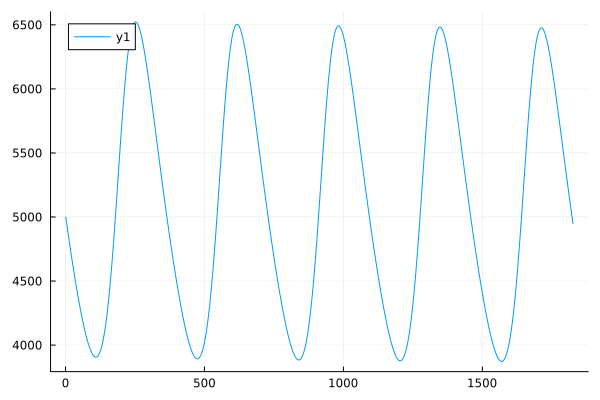

In [64]:
plot(ode_norm)

In [65]:
#Our params for fitting
n_particles = 100 #number of acceptances we want
devi = 0.975 #how close (from 0-1 with 1 being identical) do we want output to be to observed, used for threshold
threshold = sqrt((n_years*365+1)*((1-devi)^2));

In [66]:
sim_result = SimulatedABCRejection(obs, simulator_function_pop, priors, threshold, n_particles; max_iter=10000, write_progress=false)#,

GpABC.SimulatedABCRejectionOutput(1, 100, 711, 1.0682930309610759, [0.9353575748016569; 0.9356547859210314; … ; 0.9485795472508386; 0.9395965145038123;;], [0.7192771155940704, 0.8677558483119034, 1.0300353981323167, 1.000947085752489, 0.5387331017407655, 0.844100648533254, 1.0240130896581503, 0.9784438219987597, 0.97951352012096, 0.9113086296603435  …  0.8912261191151318, 0.7754661611408448, 0.7600165932135032, 0.8083506085896263, 0.7739295400928632, 0.6815240124568605, 0.6478772520399432, 0.955035943495728, 0.8742711959279251, 0.7833346836500391], [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01  …  0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

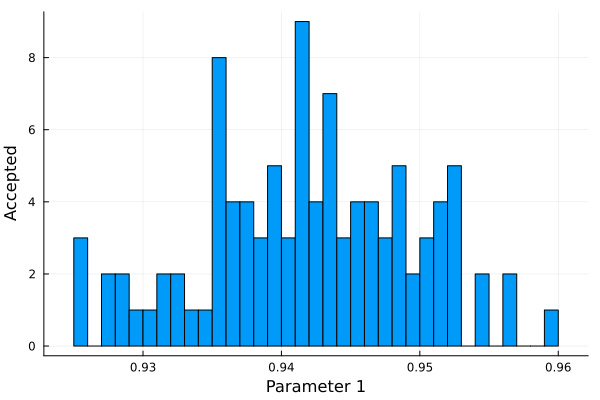

In [67]:
plot(sim_result)

In [ ]:
data = sim_result.population
vars = ["g"]
for i in 1:1
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

### Fitting ASF

Here we are fitting the diease dynamics to previously observed effects from outbreaks in the Baltic States

In [26]:
start_day = 180 #want a mid year seed
n_runs = 5  
n_years = 10
Tspan = (start_day,365*n_years+start_day)

input = ASF_Inputs.Model_Data(input_path, 0.3444);

params = ASF_Model.convert(input.Parameters)
#params[15] = 1
U0 = input.U0

Burn_U0 =  copy(U0)
Burn_U0[2:5:end] .= 0
Burn_U0[3:5:end] .= 0
rj_burn = RegularJump(ASF_Model.asf_model_pop, regular_c, eqs*nt)
prob_burn = DiscreteProblem(Burn_U0,(0.0,1*365),params)
jump_prob_burn = JumpProblem(prob_burn, Direct(), rj_burn)
sol_burn = solve(jump_prob_burn, SimpleTauLeaping(),dt=1);

U_burn = copy(sol_burn[params[18]+start_day]); #population at start date
rr = rand(1:nt) #seeding diease in starting pop
ra = rr -1
if U_burn[ra*5+1] > 1
    U_burn[ra*5+1] = 0
    U_burn[ra*5+2] = 3
    U_burn[ra*5+3] = 2
else
    U_burn[ra*5+1] = 0
    U_burn[ra*5+3] = 1
end

netw = params[3][:,rr] #related populations
cons = findall(>(0), netw)
wanted=shuffle(cons)[1:4] #seeding in 4 other pops so 5 in total!
for i in cons
    i1 = i -1
    if U_burn[i1*5+1] > 1
        U_burn[i1*5+1] = 0
        U_burn[i1*5+2] = 3
        U_burn[i1*5+3] = 2
    else
        U_burn[i1*5+1] = 0
        U_burn[i1*5+3] = 1
    end

end

rj = RegularJump(ASF_Model.asf_model_one, regular_c, eqs*nt)
prob = DiscreteProblem(U_burn,Tspan,params)
jump_prob = JumpProblem(prob,Direct(),rj)
ensemble_prob = EnsembleProblem(jump_prob)
output = solve(ensemble_prob, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1)

#output = solve(jump_prob,dt=1,SimpleTauLeaping())


EnsembleSolution Solution of length 5 with uType:
ODESolution{Int16, 2, Vector{Vector{Int16}}, Nothing, Nothing, StepRange{Int64, Int64}, Nothing, DiscreteProblem{Vector{Int16}, Tuple{Int64, Int64}, true, Vector{Any}, DiscreteFunction{true, SciMLBase.FullSpecialize, SciMLBase.var"#192#193", Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, SimpleTauLeaping, SciMLBase.ConstantInterpolation{StepRange{Int64, Int64}, Vector{Vector{Int16}}}, Nothing, Nothing}

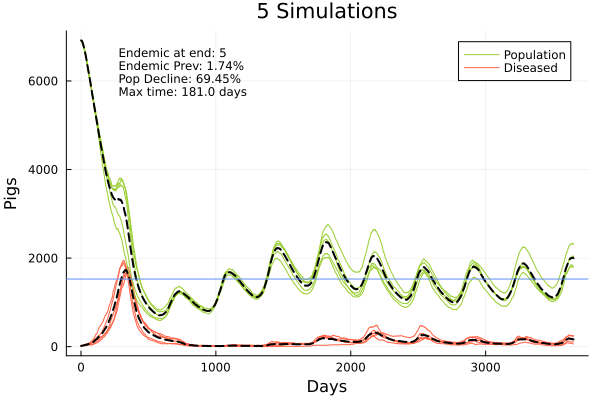

In [27]:
plot()
s = 0
ep = 0
mt = 0
pd = 0
detection_p = 0.05
pop_K = 5000
dd = zeros(365*n_years+1)
pp = zeros(365*n_years+1)
starting_p = detection_p*pop_K

for i in 1:n_runs
    if n_runs == 1
        d, da,f,p = run_analysis(output)
    else
        d, da,f,p = run_analysis(output[i])
    end
    if i == 1
    plot!(p, c = "olivedrab3", label = "Population")
        plot!(d, c = "tomato", label = "Diseased")
    
    else
    plot!(d, label = "", c = "tomato")
    plot!(p, label = "", c = "olivedrab3")
    end
    if d[end] > 0

        ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
        pd += 100*(1-mean(p[3*365:end])/pop_K)

        max_d = findmax(d)[2][1]

        if maximum(d) <= starting_p
            take_off_time = 0
        else
            take_off_time = findfirst(>(starting_p), d)[1]
        end

        mt += max_d-take_off_time
        dd += d
        pp += p
        s += 1
        

    end

end
plot!(dd/s, c = "black", label = "", linestyle = :dash, linewidth = 2)
plot!(pp/s, c = "black", label = "", linestyle = :dash, linewidth = 2)

hline!([(1-pd/s/100)*pop_K],title = "$(n_runs) Simulations", label="", xlabel = "Days", ylabel = "Pigs")
annotate!(250, 6200, text(" Endemic at end: $(s) \n Endemic Prev: $(round(ep/s,digits=2))% \n Pop Decline: $(round(pd/s,digits = 2))% \n Max time: $(round(mt/s)) days", :left, 8))

In [12]:
#Important means

m_t = Normal(180,36.48)
p_d = Normal(75,6.08)
e_p = Normal(1.5,0.304)

Normal{Float64}(μ=1.5, σ=0.304)

In [13]:
function AUSF_d(dis_params,Tspan,U0)
    rj = RegularJump(ASF_Model.asf_model_one, regular_c, eqs*nt)
    prob = DiscreteProblem(U0,Tspan,dis_params)
    jump_prob = JumpProblem(prob,Direct(),rj)
    ensemble_prob = EnsembleProblem(jump_prob)
    model_outs = solve(ensemble_prob, SimpleTauLeaping(), trajectories= 3,EnsembleThreads(),dt=1)
    
    res = eval_out(model_outs)
    
end
    
function simulator_function_d(var_params)
    start_day = 180
    
    Tspan = (start_day,365*n_years+start_day)
    
    input = ASF_Inputs.Model_Data(input_path,var_params[4]);
    
    params = ASF_Model.convert(input.Parameters)
    
    U0 = input.U0

    Burn_U0 =  copy(U0)
    Burn_U0[2:5:end] .= 0
    Burn_U0[3:5:end] .= 0
    rj_burn = RegularJump(ASF_Model.asf_model_pop, regular_c, eqs*nt)
    prob_burn = DiscreteProblem(Burn_U0,(0.0,275),params)
    jump_prob_burn = JumpProblem(prob_burn, Direct(), rj_burn)
    sol_burn = solve(jump_prob_burn, SimpleTauLeaping(),dt=1);
    
    U_burn = copy(sol_burn[params[18]+start_day]); #population at start date
    rr = rand(1:nt) #seeding diease in starting pop
    ra = rr -1
    if U_burn[ra*5+1] > 1
        U_burn[ra*5+1] = 0
        U_burn[ra*5+2] = 3
        U_burn[ra*5+3] = 2
    else
        U_burn[ra*5+1] = 0
        U_burn[ra*5+3] = 1
    end

    netw = params[3][:,rr] #related populations
    cons = findall(>(0), netw)
    
    if length(cons) <= 4
        wanted = cons
    else
        wanted=shuffle(cons)[1:4] #seeding in 4 other pops so 5 in total!
    end 
    
    for i in cons
        i1 = i -1
        if U_burn[i1*5+1] > 1
            U_burn[i1*5+1] = 0
            U_burn[i1*5+2] = 3
            U_burn[i1*5+3] = 2
        else
            U_burn[i1*5+1] = 0
            U_burn[i1*5+3] = 1
        end

    end
    #beta
    
    params[1] .= var_params[1] #intra
    params[2][params[2] .!= 0 ] .= var_params[2]/n_con #inter
    
    #corpse 
    params[8] = var_params[3] #corpse infection modifier
    AUSF_d(params, Tspan, U_burn)
    
    
end


function eval_out(data) 

    output_final = Matrix{Float64}(undef,(3,1))
    s = 0
    ep = 0
    mt = 0
    pd = 0
    detection_p = 0.05
    pop_K = 5000
    
    starting_p = detection_p*pop_K
    for i in 1:3
        d, da,f,p = run_analysis(data[i])

        if d[end] > 0
            
            ep += 100*mean(da[3*365:end])/mean(p[3*365:end])
            pd += 100*(1-mean(p[3*365:end])/pop_K)
            
            max_d = findmax(d)[2][1]
            
            if maximum(d) <= starting_p
                take_off_time = 0
            else
                take_off_time = findfirst(>(starting_p), d)[1]
            end
            
            mt += max_d-take_off_time
            s += 1

        end

    end
    
    if s >= 2
        output_final[1] = pdf.(e_p,ep/s)/pdf.(e_p,mean(e_p))
        output_final[2] = pdf.(p_d,pd/s)/pdf.(p_d,mean(p_d))
        output_final[3] = pdf.(m_t,mt/s)/pdf.(m_t,mean(m_t))

        
    else
        output_final[1] = 0
        output_final[2] = 0
        output_final[3] = 0
       
    end
   
    
    return output_final
    
end

function observed_params()
   
    obs =  Matrix{Float64}(undef,(3,1))
    
    obs[1] = 1 #2.5 #endemic prev
    obs[2] = 1#80 #population delcine %
    obs[3] = 1#8 month #time (days) from init to max
    
    return obs
end

observed_params (generic function with 1 method)

In [14]:
schedule_sig = [1,3/4,1/2];
thresh_shed = zeros(length(schedule_sig))
for (i,v) in enumerate(schedule_sig)
    thresh_shed[i] =  sqrt(3*(pdf.(e_p,(1.5)-0.75*v)/pdf.(e_p,2.5)-1)^2)
end

In [30]:
wa = quantile.(m_t, 0.15)

142.19090995126658

In [31]:

xa = pdf.(m_t,wa)/pdf.(m_t,mean(m_t))

0.5844423785292151

In [32]:
sqrt(3*(1-xa)^2)

0.7197669138598748

In [18]:
thresh_shed = [1.2841903149896468,0.7197669138598748, 0.5165660265550855]

3-element Vector{Float64}:
 1.2841903149896468
 0.7197669138598748
 0.5165660265550855

In [19]:
input_path = "/home/callum/ASF/Inputs/"; #path to model data
n_years = 10 #how many years each sim will run for
n_runs = 3 #how many runs for each param
n_con = 6  # average number of connections each group has
obs = observed_params() #our observed (just array of ones, we normalise output to be relative to this)
priors = [Uniform(0.1, 1.0), Uniform(0.01, 0.1), Uniform(0, 1.0), Uniform(0,0.5)];

In [20]:
n_particles = 250;

In [21]:
sim_abcsmc_res = SimulatedABCSMC(obs,simulator_function_d,priors,thresh_shed,n_particles; write_progress=true)

┌ Info: GpABC rejection simulation. ϵ = 1.2841903149896468.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.7197669138598748
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 176/1000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.5165660265550855
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 74/1000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 140/2000 particles.
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:238
┌ Warning: Simulation reached maximum 2500 iterations before finding 250 particles - will return 165
└ @ GpABC /home/callum/.julia/packages/GpABC/o0EN1/src/abc/smc.jl:248


GpABC.SimulatedABCSMCOutput(4, [250, 250, 165], [748, 1397, 2500], [1.2841903149896468, 0.7197669138598748, 0.5165660265550855], AbstractMatrix{Float64}[[0.1383036374201574 0.04726204134842103 0.7649243662367097 0.09246929269463589; 0.26363062347777977 0.07757676323516112 0.41489116793454306 0.10785935257833806; … ; 0.6354494282508568 0.06577962367419986 0.23999838568106668 0.3743152146555348; 0.6531966304250196 0.04784765936771146 0.485128799980855 0.38364325932399085], [0.9441982659595178 0.0375543431149537 0.4537953478837711 0.4648514671562162; 0.6955686726243013 0.04556221308235902 0.375706998027182 0.34112743879306107; … ; 0.47883953554412145 0.09340547233957183 0.5330672257312907 0.09127534305238869; 0.4400895496045905 0.03721260381923948 0.7723128652816824 0.23775230427584124], [0.7274193218541221 0.058469330292893924 0.38107256200428635 0.2526332148497516; 0.455626196580221 0.04855588238202803 0.5946824659320047 0.3261079626687996; … ; 0.5139506270570514 0.055939926457169414 0.

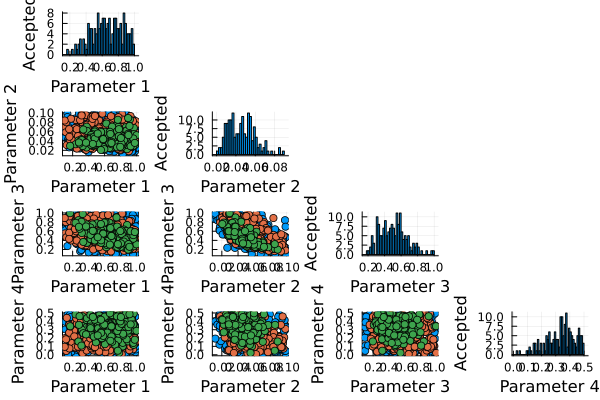

In [22]:
plot(sim_abcsmc_res)

In [23]:
data = sim_abcsmc_res.population[1]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.5592
Mean: 0.5722

β_inter
Median: 0.0485
Mean: 0.0526

ω
Median: 0.5241
Mean: 0.541

p
Median: 0.2052
Mean: 0.2267



In [24]:
data = sim_abcsmc_res.population[2]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.5614
Mean: 0.5674

β_inter
Median: 0.0522
Mean: 0.054

ω
Median: 0.533
Mean: 0.5506

p
Median: 0.2192
Mean: 0.2402



In [25]:
data = sim_abcsmc_res.population[3]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end

β_intra
Median: 0.6659
Mean: 0.664

β_inter
Median: 0.0451
Mean: 0.0457

ω
Median: 0.5047
Mean: 0.5047

p
Median: 0.3444
Mean: 0.3317



In [28]:
sim_abcsmc_res.population

3-element Vector{AbstractMatrix{Float64}}:
 [0.1383036374201574 0.04726204134842103 0.7649243662367097 0.09246929269463589; 0.26363062347777977 0.07757676323516112 0.41489116793454306 0.10785935257833806; … ; 0.6354494282508568 0.06577962367419986 0.23999838568106668 0.3743152146555348; 0.6531966304250196 0.04784765936771146 0.485128799980855 0.38364325932399085]
 [0.9441982659595178 0.0375543431149537 0.4537953478837711 0.4648514671562162; 0.6955686726243013 0.04556221308235902 0.375706998027182 0.34112743879306107; … ; 0.47883953554412145 0.09340547233957183 0.5330672257312907 0.09127534305238869; 0.4400895496045905 0.03721260381923948 0.7723128652816824 0.23775230427584124]
 [0.7274193218541221 0.058469330292893924 0.38107256200428635 0.2526332148497516; 0.455626196580221 0.04855588238202803 0.5946824659320047 0.3261079626687996; … ; 0.5139506270570514 0.055939926457169414 0.4671906075129361 0.23158657322288212; 0.7655835427587107 0.08526784886249805 0.3167148983921184 0.04837772354

In [ ]:
data = sim_abcsmc_res.population[3]
vars = ["β_intra", "β_inter", "ω", "p"]
for i in 1:4
    wanted = data[:,i]
    println(vars[i])
    println("Median: ", round(median(wanted),digits=4))
    println("Mean: ", round(mean(wanted), digits=4))
    
    println()
end